# Australian Geoscience Datacube API
Perform band maths and produce a Normalised Difference Vegetation Index (NDVI) file.

In [1]:
from pprint import pprint
%matplotlib inline
from matplotlib import pyplot as plt
import xarray
import datacube.api

In [2]:
dc = datacube.api.API()

In [7]:
nbar = dc.get_dataset(product='NBAR', platform='LANDSAT_5', 
                      y=(-34.95,-35.05), x=(148.95,149.05)
                )

In [8]:
nbar.data_vars.keys()

['crs', u'band_70', u'band_10', u'band_20', u'band_50', u'band_40', u'band_30']

We are working on a semantics layer to be able to use alias for band names, but for now, we have to rely on the knowledge that band_30 is red, and band_40 is near-infrared.

In [9]:
red = nbar.band_30
nir = nbar.band_40

We can select the first time index and plot the first timeslice.

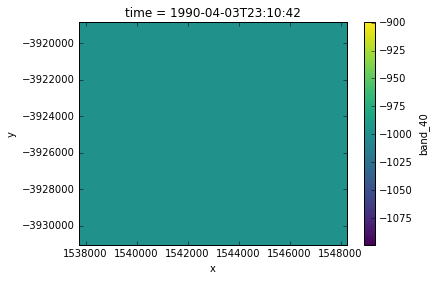

In [11]:
nir.isel(time=2).plot()

We can also select a range on the spatial dimensions.

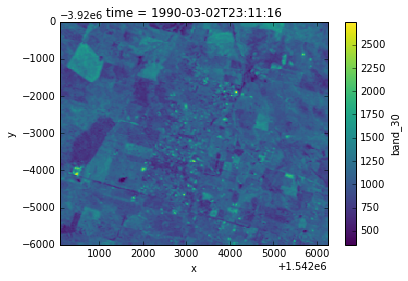

In [12]:
red.isel(time=0).sel(y=slice(-3920000.5,-3926000.5), x=slice(1542112, 1563962)).plot()

NDVI compares the red and near-infrared bands:

In [13]:
ndvi = (nir - red) / (nir + red)
ndvi.name = 'Normalised Difference Vegetation Index'

The `ndvi` array has values across the spatial and time dimensions.

In [14]:
ndvi

<xarray.DataArray 'Normalised Difference Vegetation Index' (time: 182, y: 489, x: 420)>
dask.array<elemwis..., shape=(182, 489, 420), dtype=int16, chunksize=(27, 489, 420)>
Coordinates:
  * time     (time) datetime64[ns] 1990-03-02T23:11:16 1990-03-02T23:11:39 ...
  * y        (y) float64 -3.919e+06 -3.919e+06 -3.919e+06 -3.919e+06 ...
  * x        (x) float64 1.538e+06 1.538e+06 1.538e+06 1.538e+06 1.538e+06 ...

We can select an individual time layer to make a labelled plot:

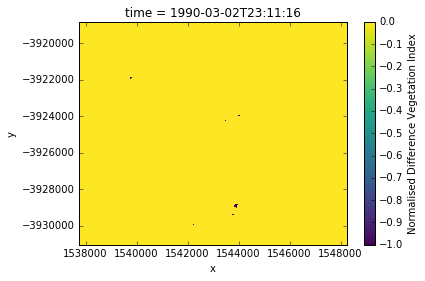

In [15]:
ndvi.isel(time=0).plot()

We have set up the calculation of NDVI to happen for all timeslices. It will be computed when the data is requested, either explicitly by calling `ndvi.load()`, or by a function that accesses the data, such as plotting:
(This can take a while...)

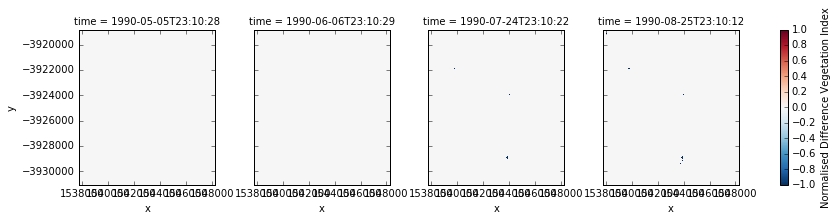

In [16]:
ndvi.isel(time=[3,4,9,13]).plot(col='time')

The xarray can be turned into a Dataset, which can then be saved across all of the timeseries to a NetCDF file.

In [17]:
ds_ndvi = ndvi[:100,:100,:100].to_dataset(name='ndvi')
ds_ndvi.to_netcdf('ndvi.nc')

### Transposing dimensions

In [18]:
visible = dc.get_data_array(product='NBAR', platform='LANDSAT_5', 
                      y=(-35.26,-35.32), x=(149.09,149.17), 
                      variables=['band_10', 'band_20', 'band_30'])
visible.dims

(u'variable', u'time', u'y', u'x')

We will clip and scale the image to improve the contrast of the visible bands.

In [19]:
fake_saturation = 1500
clipped_visible = visible.where(visible<fake_saturation).fillna(fake_saturation)
max_val = clipped_visible.max(['y', 'x'])
scaled = (clipped_visible / max_val)

In [20]:
rgb = scaled.transpose('time', 'y', 'x', 'variable')
rgb.dims

('time', 'y', 'x', 'variable')

/g/data/v10/public/modules/agdc-py2-env/anaconda2-2.5.0/envs/agdc/lib/python2.7/site-packages/dask/array/core.py:2014: RuntimeWarning: invalid value encountered in less
  return op(*args2)


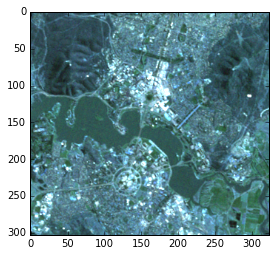

In [21]:
plt.imshow(rgb.isel(time=16))

In [22]:
import matplotlib.image
matplotlib.image.imsave('ndvi.png', rgb.isel(time=16))

## Behind the scenes

The ndvi result is performed by chaining a series of operations together on a per-chunk basis. The execution tree, including the masking on the `nodata` value done by the API, ends up being the same for each chunk. The graph can be read from the bottom up, with the ouput array chunks at the top.
(Double-click the tree-graph image below to zoom)

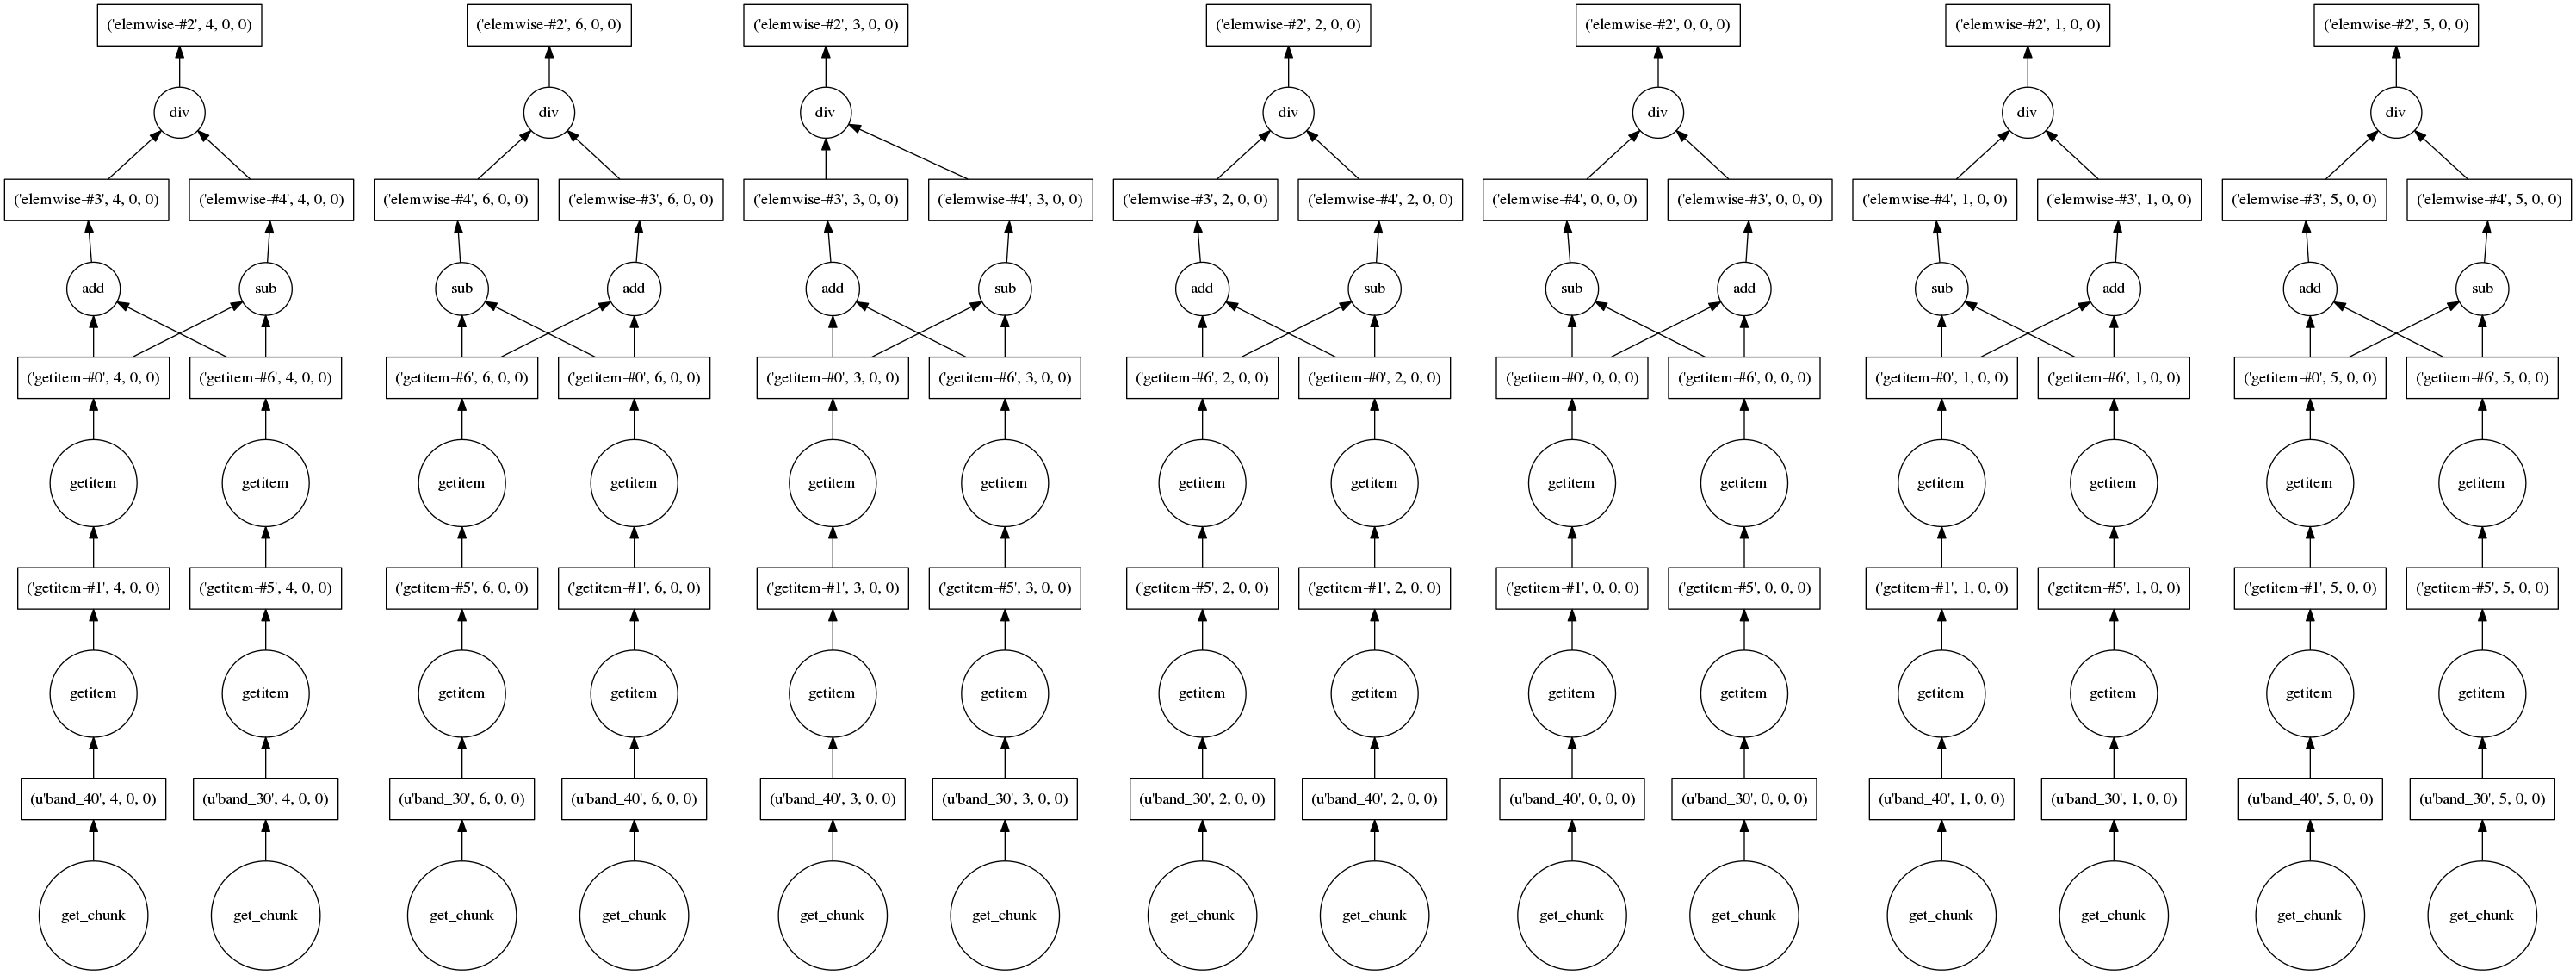

In [23]:
ndvi.data.visualize()

If we look at a single chunk, the NDVI calculation can be seen where the lines cross over to the `add` and `sub` circles.
Some optimizarion has taken place: the `div` operation has been combined with another inline function, and the other chunks have been discarded.

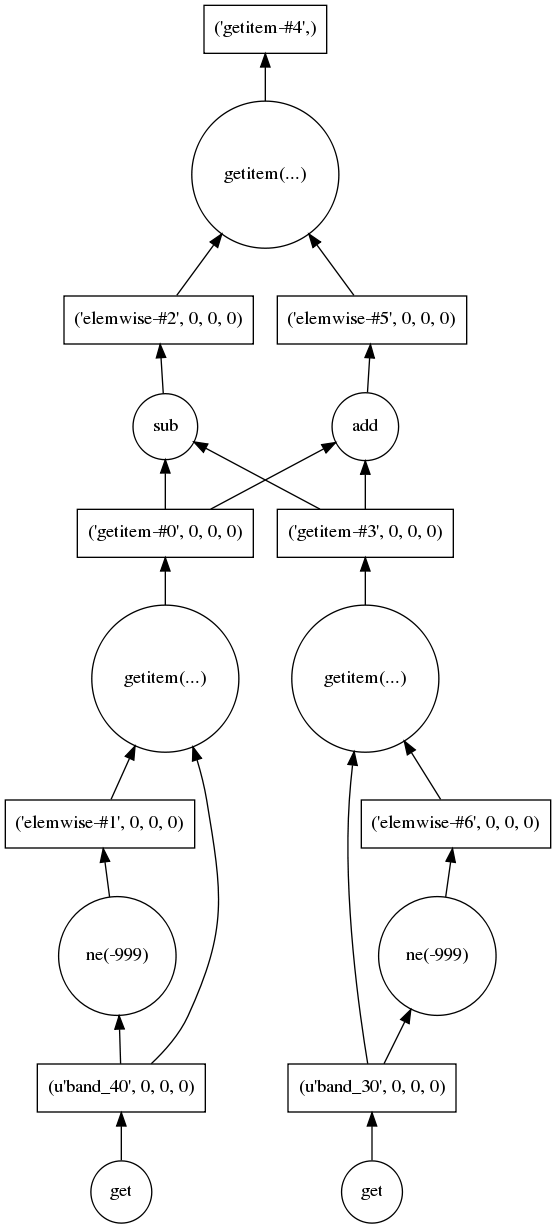

In [16]:
partial = ndvi[0,0,0]
partial.data.visualize(optimize_graph=True)